In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.FD import PixelPlot, XYScanner

20:16:17 (  +881ms) [INFO   ] -- import logging
20:16:17 (  +166ms) [INFO   ] -- import numpy as np
20:16:17 (   +11ms) [INFO   ] -- import uncertainties
20:16:17 (  +417ms) [INFO   ] -- import pandas as pd
20:16:17 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
20:16:17 (    +2ms) [INFO   ] -- import binaries.tools as tools
20:16:18 (  +453ms) [INFO   ] -- import matplotlib.pyplot as plt
20:16:18 (  +644ms) [INFO   ] -- import seaborn as so
20:16:18 (    +3ms) [INFO   ] -- set MONI_PATH = PosixPath('/cr/work/filip/monit_and_sd')
20:16:18 (    +0ms) [INFO   ] -- set HIST_PATH = PosixPath('/cr/work/filip/monit_and_sd')
20:16:18 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/cr/data01/filip/plots')
20:16:18 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/cr/data01/filip/Data')
20:16:18 (    +1ms) [INFO   ] -- import plotting.tools as plot
20:16:18 (   +14ms) [DEBUG  ] -- font size set to 9.5
20:16:18 (    +0ms) [DEBUG  ] -- label size set to 13.0
20:16:18 ( 

In [2]:
import os
from collections import defaultdict

SCANNER_RUNLISTS = "/cr/data01/filip/xy-calibration/config/calib_runlists/"

def reject(run):
    if not run: return True
    # elif run == '16407': return False      # test
    
    else:
        return False

run_data = defaultdict(list)
for LIST in os.listdir(SCANNER_RUNLISTS):
    if 'va' in LIST or 'testing' in LIST: continue

    runlist = XYScanner.load_runlist(LIST[11:18])
    runlist = XYScanner.get_good_runs(runlist)

    for run, info in runlist.iterrows():
        if reject(run): continue

        run_data[info['tel'].upper()].append([run, info['date']])

FileNotFoundError: cr/data01/filip/xy-calibration/config/pixel_masks/ll6-xp3062.txt not found.

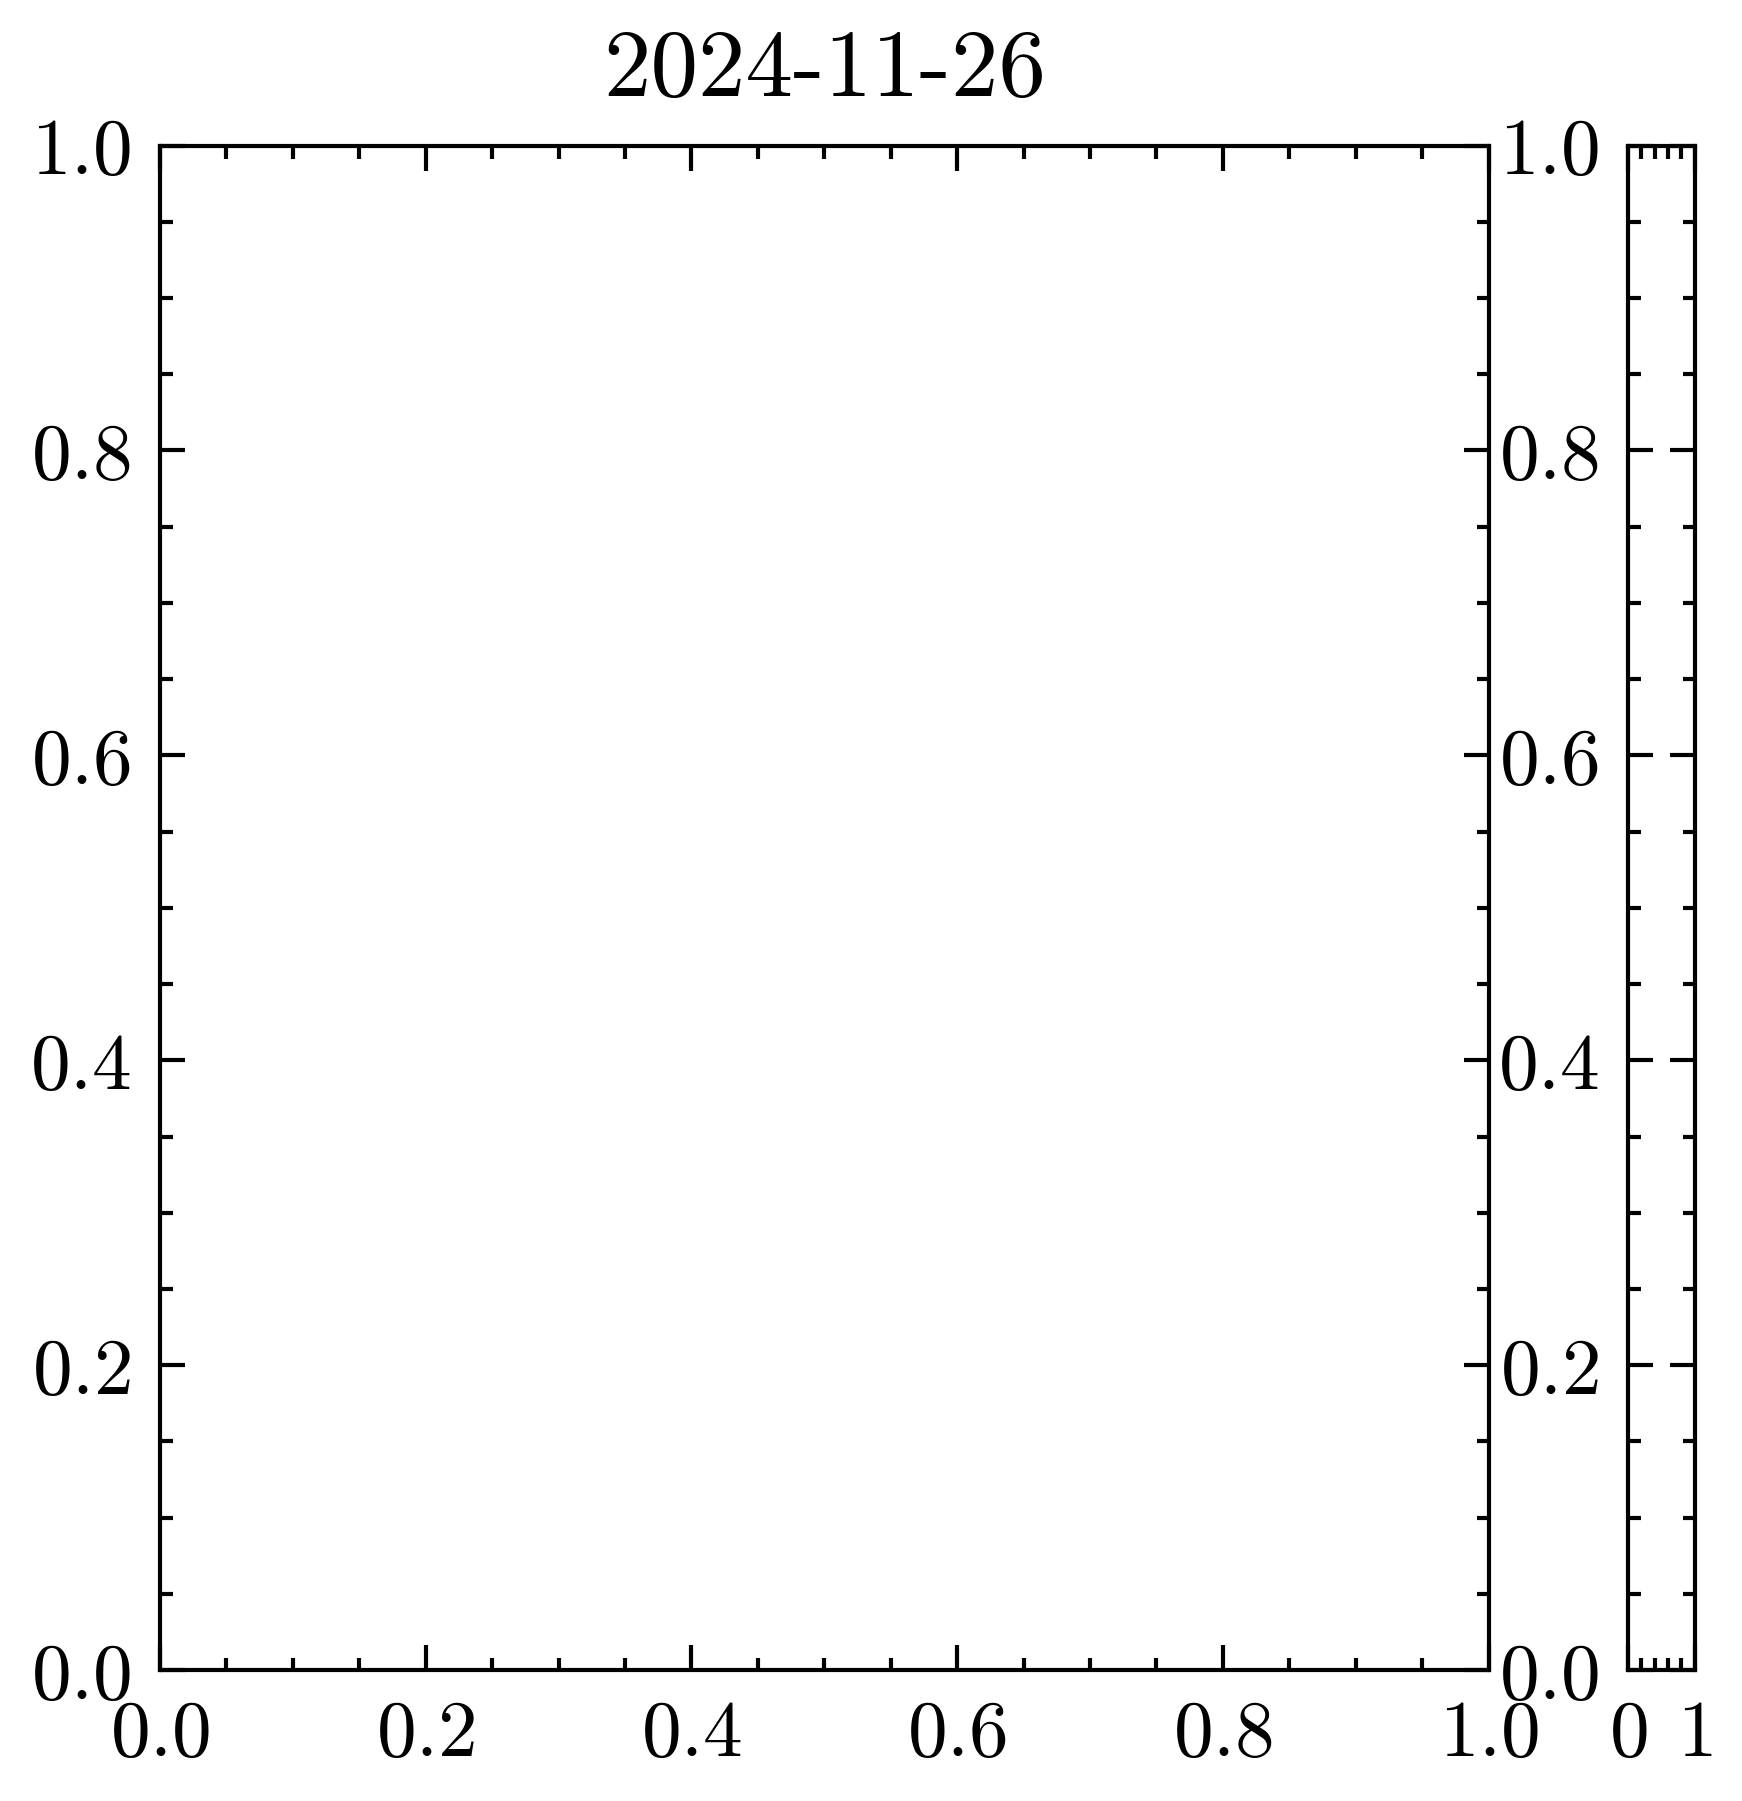

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

for tel, runs in run_data.items():

    if "LL" not in tel: continue
    n_measurements = len(runs)

    fig, axes = plt.subplots(1, n_measurements + 1, figsize=[n_measurements * 3.3, 3.3], width_ratios=[1] * n_measurements + [0.05])
    for ax, (_id, _date) in zip(axes, runs): 
        ax.set_title(_date)

        std, xy = np.loadtxt(f'/cr/data01/filip/xy-calibration/results/outCorr_{_id}.txt', usecols=[3, 4], unpack=True)

        if tel == "LL1":
            pixel_mask = np.loadtxt('/cr/data01/filip/xy-calibration/config/pixel_masks/ll1.txt', usecols=[1], dtype=bool)
            xy[~pixel_mask] = np.nan
            std[~pixel_mask] = np.nan
        elif tel == "LL6":
            pixel_mask = np.loadtxt('/cr/data01/filip/xy-calibration/config/pixel_masks/ll6-xp3062.txt', usecols=[1], dtype=bool)
            xy[~pixel_mask] = np.nan
            std[~pixel_mask] = np.nan

        PixelPlot(ratio := xy / std, ax=ax, cmap='Reds', vmin=1, vmax=2)

        ax.text(0.5, 0.96, fr"$\tilde{{r}}$ = {np.nanmedian(ratio):.2f}, $\breve{{r}} = {np.nanmin(ratio):.2f}$, $\hat{{r}} = {np.nanmax(ratio):.2f}$",
                 ha='center',
                 va='top',
                 transform=ax.transAxes,
                 bbox=dict(boxstyle="round",ec='none',fc='white',alpha=0.7))

    plt.subplots_adjust(wspace=0.04)
    axes[0].text(-0.07, 0.5, tel,
                 ha='center',
                 va='center',
                 rotation=90,
                 transform=axes[0].transAxes,
                 fontsize='xx-large')
    plt.subplots_adjust(wspace=0.04)
    plt.colorbar(ScalarMappable(cmap='Reds', norm=Normalize(1, 2)), cax=axes[-1], shrink=0.7, label="XY calib. corr. / std. calib.")

    plot.save(fig, f'calXY_vs_calA_pixel_plots/{tel}')
    plt.close(fig)
    # break
